<a href="https://colab.research.google.com/github/JesalMP/DataVisualization-CSE3020/blob/main/DV_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 38.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# PRE

In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import plotly.express as px
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
%matplotlib inline


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Libraries to define the required functions
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [ ]:
from pmdarima.model_selection import train_test_split as time_train_test_split

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
crypto='BTC'
currency='EUR'
days='1000'
target_col = 'close'
res = requests.get(endpoint + '?fsym='+crypto+'&tsym='+currency+'&limit='+days)
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist1=hist.copy()
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

In [ ]:
curr2='INR'
ep='http://api.exchangeratesapi.io/v1/latest?access_key=e62048fb215eba7c12a2e49540ef9a2d&symbols='+curr2+'&format=1'

res1 = requests.get(ep)
hist2 = pd.DataFrame(json.loads(res1.content))
j1=json.loads(res1.content)
j1

{'base': 'EUR',
 'date': '2022-04-26',
 'rates': {'INR': 81.733756},
 'success': True,
 'timestamp': 1650990783}

In [ ]:
curr3=j1['rates'][curr2]
curr3

81.733756

In [ ]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)
hist1.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)


In [ ]:
hist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-04-22,37754.61,36352.52,37393.32,5761.04,2.139875e+08,36821.84
2022-04-23,37076.44,36437.61,36821.84,1962.28,7.220019e+07,36584.45
2022-04-24,37032.21,36186.58,36584.45,3434.43,1.258519e+08,36528.79
2022-04-25,37870.46,35608.53,36528.79,8529.22,3.108082e+08,37746.68
2022-04-26,38173.26,36020.08,37746.68,4948.31,1.849263e+08,36277.32


In [ ]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-07-31,9107.56,8582.22,8593.74,10694.45,95093364.82,9102.95
2019-08-01,9432.99,8945.47,9102.95,9870.26,90434180.84,9379.58
2019-08-02,9598.37,9317.78,9379.58,9397.06,88763993.98,9473.02
2019-08-03,9806.62,9456.16,9473.02,5768.98,55961897.54,9726.86
2019-08-04,9952.28,9486.65,9726.86,6344.14,61843051.94,9873.96


In [ ]:
hist.isnull().values.any()

False

# LSTM

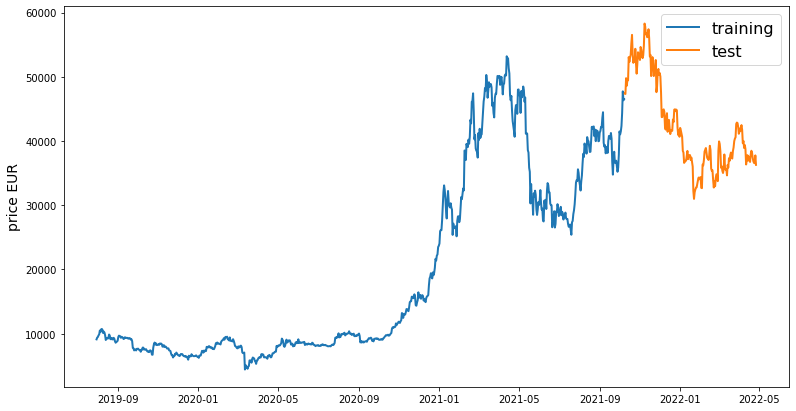

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price '+ currency, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:

np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer =  'adam'
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
25/25 [==============================] - 4s 36ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 2/20
25/25 [==============================] - 0s 9ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 3/20
25/25 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 4/20
25/25 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 5/20
25/25 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 6/20
25/25 [==============================] - 0s 9ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 7/20
25/25 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 8/20
25/25 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/20
25/25 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 10/20
25/25 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 11/20
25/25 

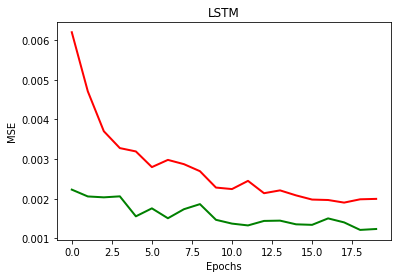

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.026137709040875198

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0012363945626699786

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.714491624505406

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
frame = { 'Actual': targets, 'Predicted': preds }
dfLSTM = pd.DataFrame(frame)

In [ ]:
dfLSTM['Predicted'] = dfLSTM['Predicted'].astype(int) 
dfLSTM['Actual']=dfLSTM['Actual']*curr3
dfLSTM['Predicted']=dfLSTM['Predicted']*curr3
dfLSTM

,Actual,Predicted
time,,
2021-10-14,4.041374e+06,3.965804e+06
2021-10-15,4.336295e+06,4.011329e+06
2021-10-16,4.275014e+06,4.278680e+06
2021-10-17,4.329659e+06,4.332461e+06
2021-10-18,4.367174e+06,4.331644e+06
...,...,...
2022-04-22,3.009587e+06,3.051285e+06
2022-04-23,2.990185e+06,3.059376e+06
2022-04-24,2.985635e+06,3.004451e+06


In [ ]:
dfLSTM['Predicted'] = dfLSTM['Predicted'].astype(int) 
dfLSTM['Actual'] = dfLSTM['Actual'].astype(int) 
dfLSTM

,Actual,Predicted
time,,
2021-10-14,4041373,3965803
2021-10-15,4336294,4011329
2021-10-16,4275013,4278680
2021-10-17,4329658,4332461
2021-10-18,4367173,4331643
...,...,...
2022-04-22,3009587,3051284
2022-04-23,2990184,3059376
2022-04-24,2985635,3004451


In [ ]:

fig = px.line(dfLSTM, x=dfLSTM.index, y=dfLSTM.columns,
              title='LSTM Output')
fig.show()

In [ ]:
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-07-31,9107.56,8582.22,8593.74,10694.45,9.509336e+07,9102.95
2019-08-01,9432.99,8945.47,9102.95,9870.26,9.043418e+07,9379.58
2019-08-02,9598.37,9317.78,9379.58,9397.06,8.876399e+07,9473.02
2019-08-03,9806.62,9456.16,9473.02,5768.98,5.596190e+07,9726.86
2019-08-04,9952.28,9486.65,9726.86,6344.14,6.184305e+07,9873.96
...,...,...,...,...,...,...
2022-04-22,37754.61,36352.52,37393.32,5761.04,2.139875e+08,36821.84
2022-04-23,37076.44,36437.61,36821.84,1962.28,7.220019e+07,36584.45
2022-04-24,37032.21,36186.58,36584.45,3434.43,1.258519e+08,36528.79


In [ ]:
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-07-31,9107.56,8582.22,8593.74,10694.45,9.509336e+07,9102.95
2019-08-01,9432.99,8945.47,9102.95,9870.26,9.043418e+07,9379.58
2019-08-02,9598.37,9317.78,9379.58,9397.06,8.876399e+07,9473.02
2019-08-03,9806.62,9456.16,9473.02,5768.98,5.596190e+07,9726.86
2019-08-04,9952.28,9486.65,9726.86,6344.14,6.184305e+07,9873.96
...,...,...,...,...,...,...
2022-04-22,37754.61,36352.52,37393.32,5761.04,2.139875e+08,36821.84
2022-04-23,37076.44,36437.61,36821.84,1962.28,7.220019e+07,36584.45
2022-04-24,37032.21,36186.58,36584.45,3434.43,1.258519e+08,36528.79


In [ ]:
hist1

,time,high,low,open,volumefrom,volumeto,close
0,1564531200,9107.56,8582.22,8593.74,10694.45,9.509336e+07,9102.95
1,1564617600,9432.99,8945.47,9102.95,9870.26,9.043418e+07,9379.58
2,1564704000,9598.37,9317.78,9379.58,9397.06,8.876399e+07,9473.02
3,1564790400,9806.62,9456.16,9473.02,5768.98,5.596190e+07,9726.86
4,1564876800,9952.28,9486.65,9726.86,6344.14,6.184305e+07,9873.96
...,...,...,...,...,...,...,...
996,1650585600,37754.61,36352.52,37393.32,5761.04,2.139875e+08,36821.84
997,1650672000,37076.44,36437.61,36821.84,1962.28,7.220019e+07,36584.45
998,1650758400,37032.21,36186.58,36584.45,3434.43,1.258519e+08,36528.79
999,1650844800,37870.46,35608.53,36528.79,8529.22,3.108082e+08,37746.68


# VAR

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    #print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    '''
    Calculates statistical values whether the available data are stationary or not 
    
    Args:
        series (float64): Values of the column for which stationarity is to be checked, numpy array of floats 
        column_name (str): Name of the column for which stationarity is to be checked
    
    Returns:
        p-value that indicates whether the data are stationary or not
    ''' 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

def cointegration_test(df): 
    '''
    Test if there is a long-run relationship between features
    
    Args:
        dataframe (float64): Values of the columns to be checked, numpy array of floats 
    
    Returns:
        True or False whether a variable has a long-run relationship between other features
    ''' 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

def inverse_diff(actual_df, pred_df):
    '''
    Transforms the differentiated values back
    
    Args:
        actual dataframe (float64): Values of the columns, numpy array of floats 
        predicted dataframe (float64): Values of the columns, numpy array of floats 
    
    Returns:
        Dataframe with the predicted values
    '''
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res



In [ ]:
df=hist1.copy()
df


,time,high,low,open,volumefrom,volumeto,close
0,1564531200,9107.56,8582.22,8593.74,10694.45,9.509336e+07,9102.95
1,1564617600,9432.99,8945.47,9102.95,9870.26,9.043418e+07,9379.58
2,1564704000,9598.37,9317.78,9379.58,9397.06,8.876399e+07,9473.02
3,1564790400,9806.62,9456.16,9473.02,5768.98,5.596190e+07,9726.86
4,1564876800,9952.28,9486.65,9726.86,6344.14,6.184305e+07,9873.96
...,...,...,...,...,...,...,...
996,1650585600,37754.61,36352.52,37393.32,5761.04,2.139875e+08,36821.84
997,1650672000,37076.44,36437.61,36821.84,1962.28,7.220019e+07,36584.45
998,1650758400,37032.21,36186.58,36584.45,3434.43,1.258519e+08,36528.79
999,1650844800,37870.46,35608.53,36528.79,8529.22,3.108082e+08,37746.68


In [ ]:
for name, column in df[['open', 'high', 'low', 'close']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: open
Test Statistic                   -1.062419
p-value                           0.729824
No Lags Used                      0.000000
Number of Observations Used    1000.000000
Critical Value (1%)              -3.436906
Critical Value (5%)              -2.864435
Critical Value (10%)             -2.568311
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: high
Test Statistic                  -0.998695
p-value                          0.753740
No Lags Used                     1.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: low
Test Statistic                  -1.046780
p-value                          0.7358

In [ ]:
X = df[['open', 'high', 'low', 'close']]

trainX, testX = time_train_test_split(X, test_size=30)

In [ ]:
train_diff = trainX.diff()
train_diff.dropna(inplace = True)

In [ ]:
for name, column in train_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: open
Test Statistic                 -32.183468
p-value                          0.000000
No Lags Used                     0.000000
Number of Observations Used    969.000000
Critical Value (1%)             -3.437116
Critical Value (5%)             -2.864527
Critical Value (10%)            -2.568361
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: high
Test Statistic                -1.400837e+01
p-value                        3.752383e-26
No Lags Used                   3.000000e+00
Number of Observations Used    9.660000e+02
Critical Value (1%)           -3.437138e+00
Critical Value (5%)           -2.864537e+00
Critical Value (10%)          -2.568366e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: low
Test Statistic                -1.134153e+01
p-value                        1.051672e-20
No Lags Us

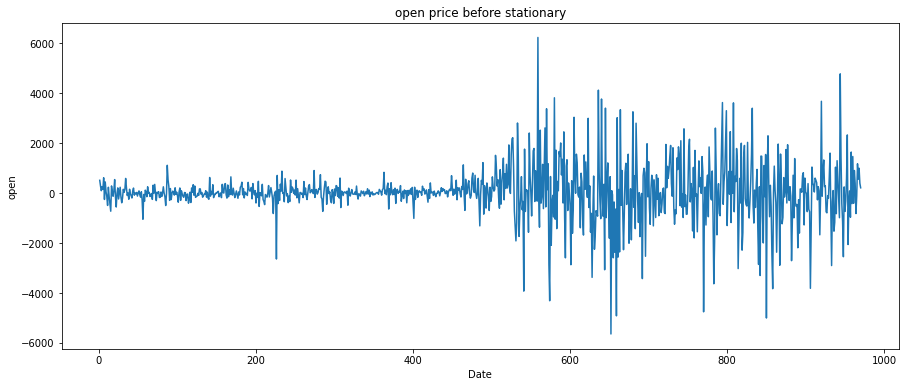

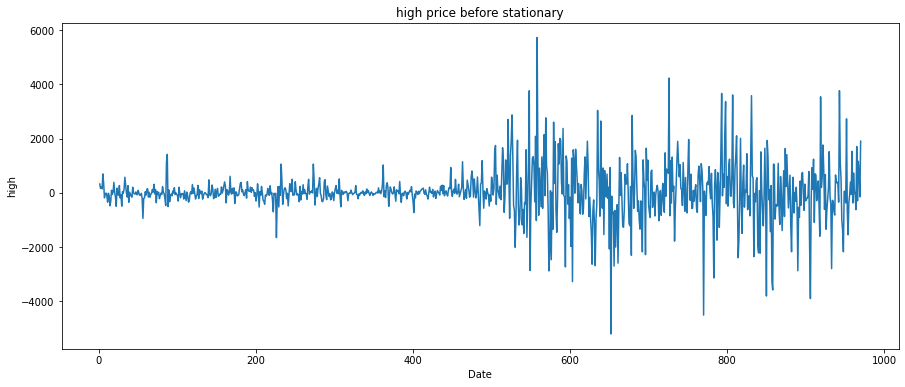

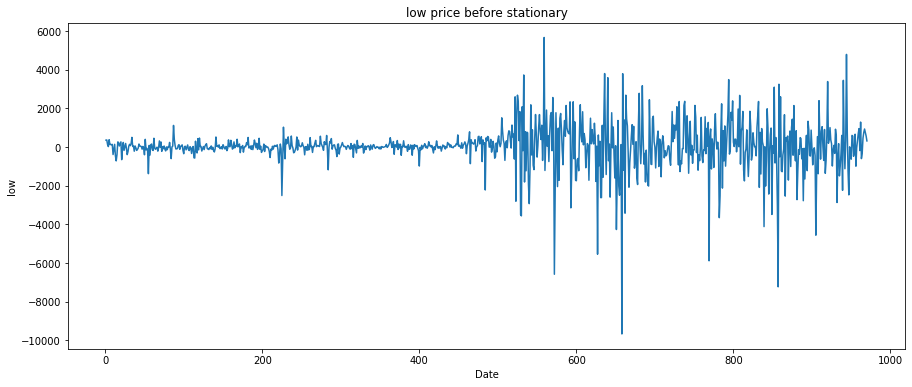

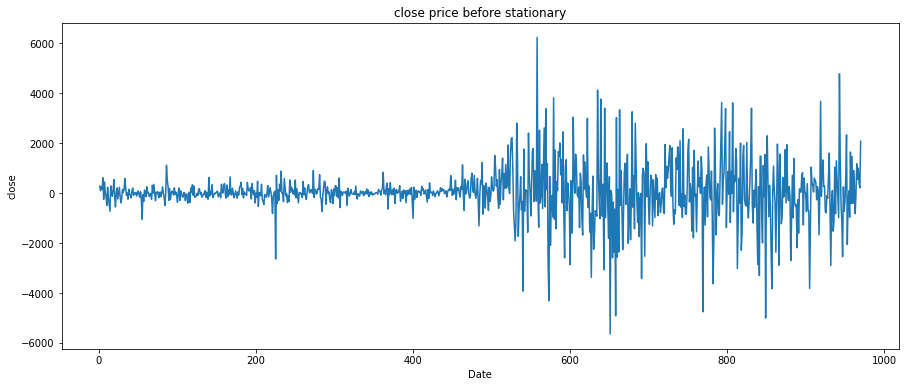

In [ ]:
for feature in train_diff:
    train_diff[str(feature)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)} price before stationary")
    plt.show()

In [ ]:
cointegration_test(train_diff)

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
open   >  1437.32   > 40.1749   =>   True
high   >  934.4     > 24.2761   =>   True
low    >  487.0     > 12.3212   =>   True
close  >  126.32    > 4.1296    =>   True


In [ ]:
train_diff

,open,high,low,close
1,509.21,325.43,363.25,276.63
2,276.63,165.38,372.31,93.44
3,93.44,208.25,138.38,253.84
4,253.84,145.66,30.49,147.10
5,147.10,697.42,385.70,611.00
...,...,...,...,...
966,1170.84,-293.81,752.98,555.40
967,555.40,1163.24,938.66,992.65
968,992.65,729.62,749.06,390.69
969,390.69,-149.34,580.53,209.35


In [ ]:
resu = []
df_results_VAR = pd.DataFrame()

for i in [1,2,3,4,5,6,7,8,9]:
    fit_v = VAR(train_diff).fit(i)
    aic = fit_v.aic
    bic = fit_v.bic
    df1 = {'AR_Term':i, 'AIC': aic, 'BIC': bic}
    df_results_VAR = df_results_VAR.append(df1, ignore_index=True)
    clist = ['AR_Term','AIC','BIC']
    df_results_VAR = df_results_VAR[clist]

In [ ]:
df_results_VAR.sort_values(by=['AIC', 'BIC'], ascending=True)

,AR_Term,AIC,BIC
8,9.0,40.728573,41.478271
7,8.0,40.739511,41.407608
6,7.0,40.797060,41.383691
5,6.0,40.823391,41.328691
4,5.0,40.905322,41.329424
3,4.0,41.025133,41.368172
2,3.0,41.148408,41.410515
1,2.0,41.438354,41.619664
0,1.0,41.872594,41.973240


In [ ]:
best_values_VAR = df_results_VAR.sort_values(by=['AIC', 'BIC']).head(1)
best_values_VAR

,AR_Term,AIC,BIC
8,9.0,40.728573,41.478271


In [ ]:
AR_Term_value_VAR = best_values_VAR['AR_Term'].iloc[0]

print("AR_Term_value_VAR: ", AR_Term_value_VAR)

AR_Term_value_VAR:  9.0


In [ ]:
model = VAR(train_diff)

results = model.fit(int(AR_Term_value_VAR))
display(results.summary())
z = results.forecast(y=train_diff.values, steps=len(testX))
df_pred = pd.DataFrame(z, columns=train_diff.columns)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Apr, 2022
Time:                     17:01:25
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    41.4783
Nobs:                     961.000    HQIC:                   41.0141
Log likelihood:          -24876.5    FPE:                4.87821e+17
AIC:                      40.7286    Det(Omega_mle):     4.19403e+17
--------------------------------------------------------------------
Results for equation open
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.004157         0.086891            0.048           0.962
L1.open         -0.900023         0.032694          -27.528           0.000
L1.high         -0.000283         0.000222           -1.272           0.203
L1.lo

In [ ]:
df_pred["new_index"] = range(len(trainX), len(X))
df_pred = df_pred.set_index("new_index")

In [ ]:
df_pred.head()

,open,high,low,close
new_index,,,,
971,2072.303908,703.460242,1470.682048,123.938874
972,124.313018,14.686337,-48.009672,-161.014833
973,-160.834132,-59.193544,-165.240761,-61.485897
974,-61.272204,-26.849387,-152.262996,-19.613913
975,-18.771108,219.028379,376.405149,498.650460


In [ ]:
res = inverse_diff(df[['open', 'high', 'low', 'close']],df_pred)
res.head()

,open,high,low,close,open_1st_inv_diff,high_1st_inv_diff,low_1st_inv_diff,close_1st_inv_diff
new_index,,,,,,,,
971,2072.303908,703.460242,1470.682048,123.938874,39818.983908,38876.720242,37490.762048,36401.258874
972,124.313018,14.686337,-48.009672,-161.014833,39943.296926,38891.406579,37442.752376,36240.244041
973,-160.834132,-59.193544,-165.240761,-61.485897,39782.462794,38832.213034,37277.511615,36178.758145
974,-61.272204,-26.849387,-152.262996,-19.613913,39721.190589,38805.363647,37125.248619,36159.144231
975,-18.771108,219.028379,376.405149,498.650460,39702.419482,39024.392026,37501.653769,36657.794692


In [ ]:
for i in ['open', 'high', 'low', 'close']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(testX[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for open
MSE is : 7824522.525332322
MAE is : 2586.8310818302175
RMSE is : 2797.2347998214814
MAPE is : 6.701153090402964
R2 is : -0.5665068414680567

Evaluation metric for high
MSE is : 6917817.433884469
MAE is : 2265.0339632807436
RMSE is : 2630.1744113051645
MAPE is : 5.576889362078809
R2 is : -0.3617721338970359

Evaluation metric for low
MSE is : 6869619.215241772
MAE is : 2250.5510650071606
RMSE is : 2620.995844186284
MAPE is : 5.733424035941182
R2 is : -0.3435895698723732

Evaluation metric for close
MSE is : 11040902.636782434
MAE is : 2432.3520118105253
RMSE is : 3322.7853732647905
MAPE is : 5.941019468355561
R2 is : -1.2737200693319726



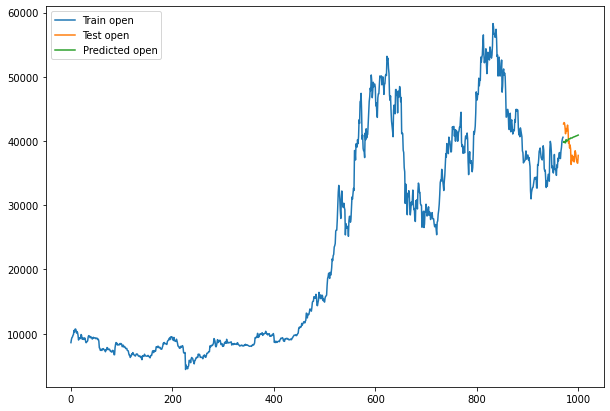

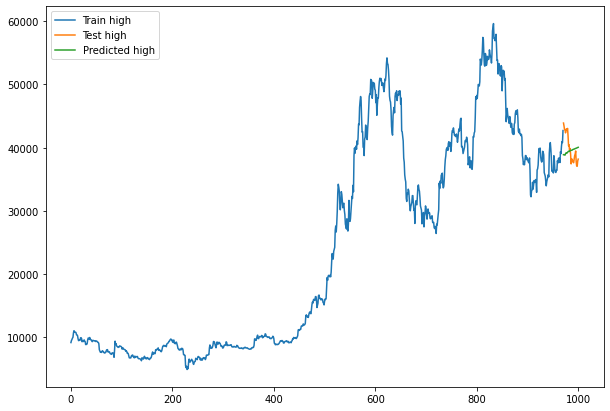

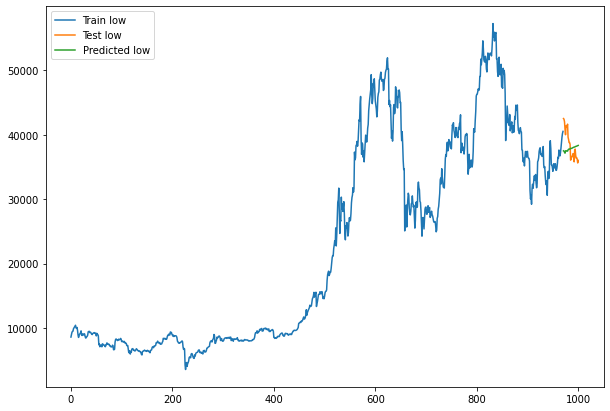

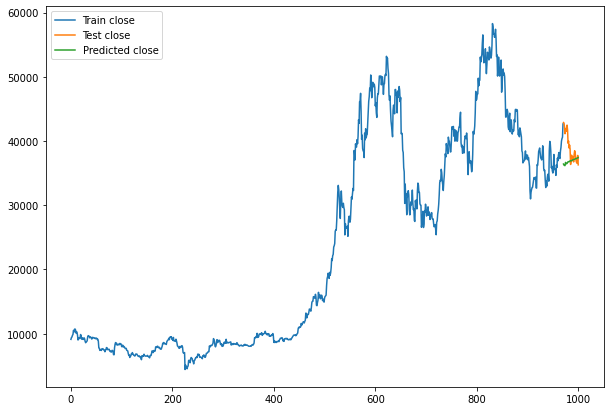

In [ ]:
for i in ['open', 'high', 'low', 'close']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(trainX[str(i)], label='Train '+str(i))
    plt.plot(testX[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

# VARMA

In [ ]:
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))

In [ ]:
df_results_VARMA = pd.DataFrame(columns=['p', 'q', 'tr','RMSE open','RMSE high','RMSE low','RMSE close'])

for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    model = VARMAX(train_diff, order=(p,q), trend=tr).fit()
    z = model.forecast(y=train_diff[['open', 'high', 'low', 'close']].values, steps=len(testX))
    df_pred = pd.DataFrame(z, columns=['open', 'high', 'low', 'close'])
    res = inverse_diff(df[['open', 'high', 'low', 'close']],df_pred)
    openrmse = np.sqrt(metrics.mean_squared_error(testX.open, res.open_1st_inv_diff))
    highrmse = np.sqrt(metrics.mean_squared_error(testX.high, res.high_1st_inv_diff))
    lowrmse = np.sqrt(metrics.mean_squared_error(testX.low, res.low_1st_inv_diff))
    closermse = np.sqrt(metrics.mean_squared_error(testX.close, res.close_1st_inv_diff))
    df_results_VARMA = df_results_VARMA.append({'p': p, 'q': q, 'tr': tr,'RMSE open': openrmse,
                                                'RMSE high':highrmse,'RMSE low':lowrmse,
                                                'RMSE close':closermse }, ignore_index=True)

In [ ]:
df_results_VARMA.sort_values(by=['RMSE open', 'RMSE high', 'RMSE low', 'RMSE close']).head()

,p,q,tr,RMSE open,RMSE high,RMSE low,RMSE close
4,1,2,n,2299.743353,2518.762997,2466.243889,3546.000564
0,1,1,n,2303.758874,2529.847595,2522.383750,3533.893046
16,2,2,n,2306.864647,2506.134622,2500.760683,3536.307994
20,2,3,n,2307.145560,2494.052746,2476.571051,3532.035341
12,2,1,n,2315.048091,2494.764344,2502.578446,3522.030279


In [ ]:
best_values_VARMA = df_results_VARMA.sort_values(by=['RMSE open', 'RMSE high', 'RMSE low', 'RMSE close']).head(1)
best_values_VARMA

,p,q,tr,RMSE open,RMSE high,RMSE low,RMSE close
4,1,2,n,2299.743353,2518.762997,2466.243889,3546.000564


In [ ]:
p_value_VARMA = best_values_VARMA['p'].iloc[0]
q_value_VARMA = best_values_VARMA['q'].iloc[0] 
tr_value_VARMA = best_values_VARMA['tr'].iloc[0] 

print("p_value_VARMA: ", p_value_VARMA)
print("q_value_VARMA: ", q_value_VARMA)
print("tr_value_VARMA: ", tr_value_VARMA)

p_value_VARMA:  1
q_value_VARMA:  2
tr_value_VARMA:  n


In [ ]:
model = VARMAX(train_diff[['open', 'high', 'low', 'close']], 
               order=(p_value_VARMA, q_value_VARMA),trends = tr_value_VARMA).fit(disp=False)
result = model.forecast(steps = len(testX))

In [ ]:
res = inverse_diff(df[['open', 'high', 'low', 'close']], result)

res.head()

,open,high,low,close,open_1st_inv_diff,high_1st_inv_diff,low_1st_inv_diff,close_1st_inv_diff
970,2071.386916,585.506880,1453.979094,-69.583923,39818.066916,38758.766880,37474.059094,36207.736077
971,-67.777565,62.263896,-117.560523,7.627160,39750.289351,38821.030776,37356.498570,36215.363236
972,7.519543,-26.063904,66.783702,36.458121,39757.808894,38794.966871,37423.282272,36251.821358
973,35.635647,61.187381,11.770991,34.410017,39793.444541,38856.154253,37435.053263,36286.231374
974,34.681011,22.559847,43.609334,34.343518,39828.125552,38878.714100,37478.662596,36320.574892


In [ ]:
for i in ['open', 'high', 'low', 'close']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(testX[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for open
MSE is : 7124655.81145071
MAE is : 2459.0358992411434
RMSE is : 2669.205089806834
MAPE is : 6.355598288236765
R2 is : -0.42639017724198647

Evaluation metric for high
MSE is : 6834234.074546634
MAE is : 2198.4187574053562
RMSE is : 2614.2368053691375
MAPE is : 5.383915095395989
R2 is : -0.3453187523657091

Evaluation metric for low
MSE is : 6662739.090975379
MAE is : 2217.736560809848
RMSE is : 2581.2282136563167
MAPE is : 5.649354344526916
R2 is : -0.30312706846305115

Evaluation metric for close
MSE is : 11606838.199913297
MAE is : 2524.8194139142606
RMSE is : 3406.8810075952606
MAPE is : 6.170572899276851
R2 is : -1.3902666135929889



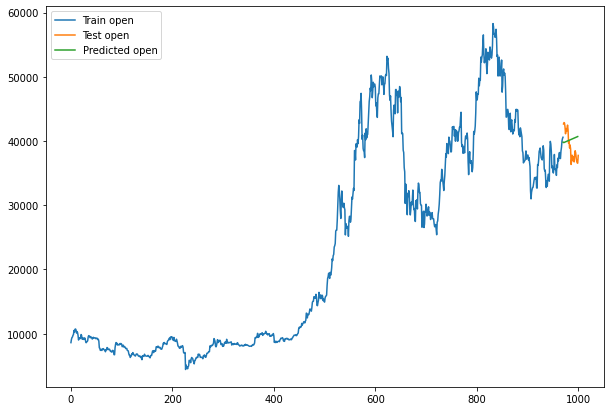

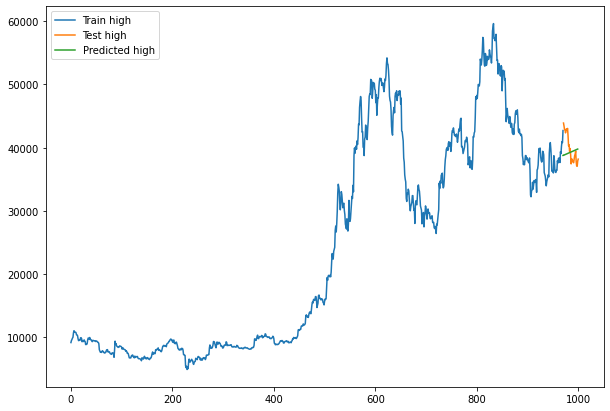

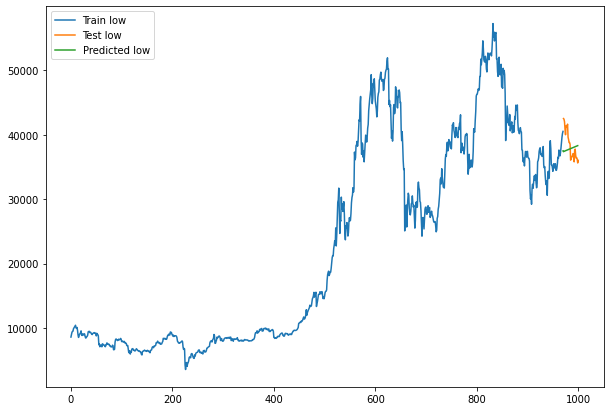

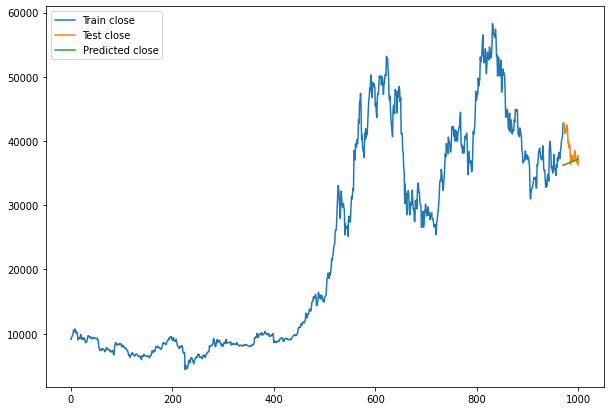

In [ ]:
for i in ['open', 'high', 'low', 'close']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(trainX[str(i)], label='Train '+str(i))
    plt.plot(testX[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()